In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import t as t_dist
import matplotlib.pyplot as plt
import os, gc

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['KMP_DUPLICATE_WARNINGS'] = 'True'
folder = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
torch.set_default_dtype(dtype)
print("Using device:", device)

g = 1.5
delta_t = 0.1
step_total = 2001
steady_tail_len = 200
alpha = 0.05
N_list = [2000,6000, 30000]     
num_J = 3                   
num_inner = 1               

master_seed = 2025
torch.manual_seed(master_seed)
np.random.seed(master_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(master_seed)
seed_table = np.random.choice(np.arange(1, 2**20), size=1000, replace=False)

def f(x, J):
    return -x + J @ torch.tanh(x)
def is_plateau(Ek_buffer, rel_tol=1e-3, min_len=100):
    if len(Ek_buffer) < min_len:
        return False
    last = np.mean(Ek_buffer[-50:])
    prev = np.mean(Ek_buffer[-90:-40])
    denom = max(abs(prev), 1e-8)
    return abs(last - prev) / denom < rel_tol

all_Ek = {}

for N in N_list:
    print(f"\n=== Simulating N={N} ===")
    all_Ek[N] = []
    for idx_J in tqdm(range(num_J), desc=f"N={N}"):
        seed_J = int(seed_table[idx_J])
        torch.manual_seed(seed_J)
        np.random.seed(seed_J)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed_J)
        J = torch.randn((N, N), device=device, dtype=dtype) * (g / np.sqrt(N))
        seed_X = seed_J + 2024
        torch.manual_seed(seed_X)
        np.random.seed(seed_X)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed_X)
        X = torch.randn(N, device=device, dtype=dtype)
        Ek_buffer = []
        steady = False
        steady_Ek = []

        for t in range(step_total):
            dX = f(X, J)
            X = X + delta_t * dX
            Ek = torch.sum(dX ** 2).item() / N
            Ek_buffer.append(Ek)

            if t > 1800:
                steady_Ek.append(Ek)
                if len(steady_Ek) >= steady_tail_len:
                    break
        if len(steady_Ek) == steady_tail_len:
            all_Ek[N].append(np.array(steady_Ek))
        else:
            print(f"Warning: N={N}, J_idx={idx_J} 未达到稳态")
        del J, X
        if torch.cuda.is_available():
            torch.cuda.empty_cache()





Using device: cuda

=== Simulating N=2000 ===


N=2000: 100%|██████████| 3/3 [00:10<00:00,  3.35s/it]



=== Simulating N=6000 ===


N=6000: 100%|██████████| 3/3 [00:14<00:00,  4.96s/it]



=== Simulating N=30000 ===


N=30000: 100%|██████████| 3/3 [24:54<00:00, 498.08s/it]


N=2000  Ek_min=0.0066,  Ek_max=0.0326,  DMFT=0.0220
N=6000  Ek_min=0.0173,  Ek_max=0.0323,  DMFT=0.0220
N=30000  Ek_min=0.0181,  Ek_max=0.0266,  DMFT=0.0220


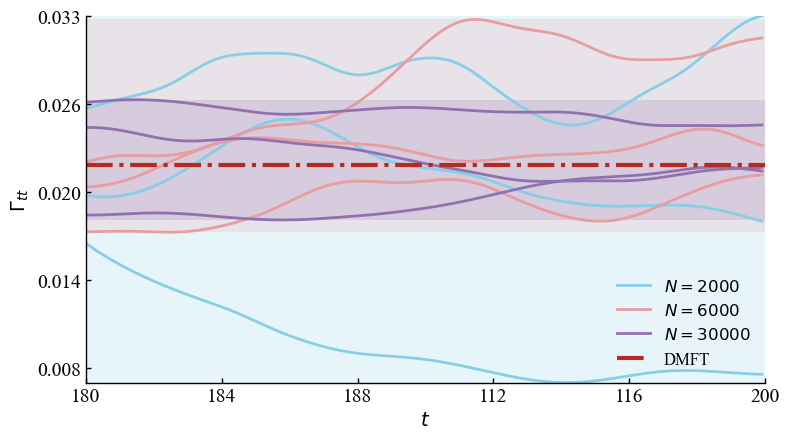

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib
from matplotlib.ticker import FuncFormatter
import os
import pandas as pd

matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['legend.frameon'] = False

try:
    folder = os.path.dirname(os.path.abspath(__file__))
except NameError:
    folder = os.getcwd()
glist = [1.1, 1.3, 1.5]   
filename = f"DMFT_kinetic_vs_g{glist[0]:.2f}to{glist[-1]:.2f}.csv"
df_dmft = pd.read_csv(os.path.join(folder, filename))
Ek_DMFT = (df_dmft['Gamma0'])[2]
N_list = [2000,6000, 30000]
fig, ax = plt.subplots(figsize=(8, 4.5))
color_dict = { 2000: "#88CEE6",6000: "#E89DA0", 30000:'#9271B1' }
for N in N_list:
    trajs = all_Ek[N]
    if len(trajs) == 0:
        continue
    t = np.arange(steady_tail_len) * delta_t
    t1 = np.arange(steady_tail_len+1) * delta_t
    Ek_all = np.array(trajs)
    Ek_min, Ek_max = Ek_all.min(), Ek_all.max()
    Ek_mean = Ek_all.mean()
    print(f"N={N}  Ek_min={Ek_min:.4f},  Ek_max={Ek_max:.4f},  DMFT={Ek_DMFT:.4f}")
    ax.fill_between( t1, Ek_min, Ek_max, color=color_dict[N], alpha=0.2,  linewidth=0  )

    for j, Ek_traj in enumerate(trajs[:3]):
        ax.plot(t, Ek_traj, lw=2,
                color=color_dict[N],
                alpha=1.0,
                label=f"$N={N}$" if j == 0 else None)

ax.axhline(Ek_DMFT, color="#B42B22", linestyle="-.",
           linewidth=3, alpha=1.0, label="DMFT")
min =  (np.array(all_Ek[2000])).min()
max = (np.array(all_Ek[2000])).max()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

leg = ax.legend(frameon=False)
ax.set_xlim(0, 20)
ax.set_ylim(min, max)
ax.set_xlabel("$t$", fontsize=14)
ax.set_ylabel("$\Gamma_{tt}$" ,fontsize=14)
ax.legend(fontsize=12, loc="lower right")
yticks = np.linspace(min+0.001, max, 5)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y:.3f}" for y in yticks],
                   fontname='Times New Roman', fontsize=14)
ax.tick_params(axis='both', labelsize=14)

ax.set_xticks([0.0, 4, 8, 12, 16, 20])
ax.set_xticklabels(['180', '184', '188', '112', '116', '200'])
plt.savefig("Ekfluc.pdf", format="pdf")
plt.tight_layout()
plt.show()
